In [ ]:
import os
import time #keeping track how long it actually takes to run

import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import Adam
from torch.optim.lr_scheduler import ExponentialLR
from torch.utils.data import DataLoader, random_split
from torchvision.datasets import ImageFolder
import torchvision.transforms.functional as TF
import matplotlib.pyplot as plt
import torchvision.transforms as transforms
import torchvision.transforms.functional as TF
from torchvision.datasets import ImageFolder
from torch.optim import AdamW
from torchvision.transforms import RandomErasing
#Is CUDA is available?
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Checking the status of the cuda and devices that are being used

In [ ]:
#Checking the status of the cuda and devices that are being used
print(f"CUDA available: {torch.cuda.is_available()}")


CUDA available: True
Current device: 0
Device name: NVIDIA L4



Training transform with augmentation inorder to get more variety and hopefully allow the model to learn more

In [ ]:

transform_train = transforms.Compose([
    transforms.RandomHorizontalFlip(), #flipping the image randomly just horizontally I felt like vertically wasnt as necessary
    transforms.RandomRotation(25), #small rotation
    transforms.ColorJitter(brightness=0.25, contrast=0.25, saturation=0.25), #I found that this was a amount that wasnt too drastic
    transforms.ToTensor(), # I orginally had this at the end and got a PIL error
    transforms.Normalize(mean=[0.5]*3, std=[0.5]*3), #normalzing the channels rgb
    transforms.Resize((256, 256)), #I choose 128x128 at first and felt like it was limiting me to small kernal sizes
    RandomErasing(p=0.5, scale=(0.02, 0.33), ratio=(0.3, 3.3), value=0, inplace=False)
])


#There is no augmentation for testing just resizing the images to have a the same size
transform_test = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5]*3, std=[0.5]*3) #I removed this by accident and totally broke the testing output its important
])


google drive was very slow so copied it to the temp


In [ ]:
!cp -r "/content/drive/MyDrive/CNN_image_classification_animals/Source_images/DeepLearning 24-25" /content/ #google drive was very slow so copied it all over to the temp


Declare datapaths and filter out non photo files then load the testing and training data

In [ ]:
%cd /content/drive/MyDrive/CNN_image_classification_animals/
%pwd

data_dir = "/content/DeepLearning 24-25"  # path to images in the local storage was so slow otherwise
files_train = os.path.join(data_dir, "Train")
files_test = os.path.join(data_dir, "Test")


class FilteredImageFolder(ImageFolder):
    def find_classes(self, directory):
        classes = [d for d in os.listdir(directory)
                  if os.path.isdir(os.path.join(directory, d)) and not d.startswith('.')] #i had a very annoying problem where google colab put .ipynb_checkpoints into both my test and train folders i cant delete them so i filter them this way
        classes.sort()
        class_to_idx = {cls_name: i for i, cls_name in enumerate(classes)}
        return classes, class_to_idx


/content/drive/MyDrive/CNN_image_classification_animals


Creating batches and loading

In [ ]:

#Loading the testing and trainging data seperatly because they are already seperated into different folders
train_dataset = FilteredImageFolder(root=files_train, transform=transform_train)
test_dataset = FilteredImageFolder(root=files_test, transform=transform_test)

Declaring epochs

In [ ]:

Epochs = 300

Declaring the model and and save the progress to a log and save out epochs

In [ ]:

#Delcaring CNN model
model = nn.Sequential(
    #So i want a larger kernal size with a larger stride to capture the general details the overall shape ect
    nn.Conv2d(3, 32, kernel_size=4, stride=2, padding=1),
    nn.BatchNorm2d(32),
    nn.ReLU(),
    nn.MaxPool2d(2),  #so my understanding is that this is for efficency and actually changing the size of the image

    #This block is a smaller kernal to capture medium details, keeping the stride small inorder to capture all the details and not miss anything
    nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
    nn.BatchNorm2d(64),
    nn.ReLU(),
    nn.MaxPool2d(2),

    #This is going over those details again to capture any missing details I believe most of the details are captured in this size
    nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
    nn.BatchNorm2d(128),
    nn.ReLU(), #Used a Relu activation function for each
    nn.MaxPool2d(2), #my understanding is this is for efficency

    #Capturing the small details that might give some missed information
    nn.Conv2d(128, 256, kernel_size=2, stride=1, padding=1),
    nn.BatchNorm2d(256),
    nn.ReLU(),
    nn.MaxPool2d(2),  #my understanding is this is for efficency and actually resizing the images

    nn.Flatten(),
    nn.Linear(256 * 8 * 8, 512),
    nn.ReLU(),
    nn.Linear(512, 256),
    nn.ReLU(),
    nn.Dropout(0.5), #added dropout at the end inorder to push the model farther it seemed to be overfitting earily on at first. The idea of putting it here is that it doesnt impact the feature extraction
    nn.Linear(256, len(test_dataset.classes))
).to(device)
lr=0.00110 #I decided to declare these here so i could pass this to the model and log at the same time
gamma=0.9905
optimizer = AdamW(model.parameters(), lr=lr, weight_decay=1e-4) #where we declare the optomizer I experiemented with different ones I found that adam made huge improvements and then got a slight bump from adamw. I added weight decay to plentize bad predictions. I choose the value of 4 because I wanted agggresive but not too aggreesive I tested both 3 and 5
criterion = nn.CrossEntropyLoss()
scheduler = ExponentialLR(optimizer, gamma=gamma) # I added a scheduler so that i could slow down the learning rate over time inorder to not overshoot the ideal value this seemed to be happening and saw a boost when i implimented it but it isnt a exact science it is a very slow rate

#Log file for debugging
scene_name = os.path.basename(train_dataset.root.rstrip('/'))
timestamp = datetime.now().strftime("%Y-%m-%d_%H-%M-%S")
log_filename = f"{scene_name}_train_log_{timestamp}.txt"
log_file = open(log_filename, "w")

#Including all the settings for easy analysis
log_file.write(f"Training Log - {timestamp}\n")
log_file.write(f"Model Settings:\n")
log_file.write(f"  Optimizer: Adam ({lr})\n")
log_file.write(f"  Scheduler: ExponentialLR ({gamma})\n") #pulling the user input
log_file.write(f"  Dropout: 0.5\n")
log_file.write(f"  Batch size: 64\n")
log_file.write(f"  Conv layers: 4\n")
log_file.write(f"  Input size: 256x256\n")
log_file.write(f"  Conv strides: 2,1,1,1\n")
log_file.write("Epoch\tLoss\tTrain Acc\tTest Acc\tLR\tTime\n")

#Calculing accuracy for the log
def calculate_accuracy(model, data_loader):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in data_loader:
            images = images.to(device)
            labels = labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)
    return 100 * correct / total

#Where the training loop happens
start_time = time.time()
for epoch in range(Epochs): #Epochs declared above for fast access
    epoch_start = time.time()

    model.train()
    total_loss = 0.0
    train_correct = 0
    train_total = 0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        loss = criterion(outputs, labels)

        _, predicted = torch.max(outputs, 1)
        train_correct += (predicted == labels).sum().item()
        train_total += labels.size(0)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
    #getting training accuracy
    train_accuracy = 100 * train_correct / train_total

    scheduler.step()
    #getting test accuracy
    test_accuracy = calculate_accuracy(model, test_loader)
#saving out every 20 epochs it seemed often enough but not excessive that being said ideally i want to grab the best but struggled to get that to work properly
    if (epoch + 1) % 20 == 0:
        save_path = f"model_epoch_{epoch+1}.pth"
        torch.save(model.state_dict(), save_path)
        print(f"Model saved to {save_path}")

    current_lr = scheduler.get_last_lr()[0]
    epoch_time = time.time() - epoch_start

    log_line = f"{epoch+1}\t{total_loss/len(train_loader):.4f}\t{train_accuracy:.2f}\t{test_accuracy:.2f}\t{current_lr:.5f}\t{epoch_time:.2f}\n"
    print(f"Epoch {epoch+1}: Loss={total_loss/len(train_loader):.4f}, Train Acc={train_accuracy:.2f}%, Test Acc={test_accuracy:.2f}%, LR={current_lr:.5f}, Time={epoch_time:.2f}s")
    log_file.write(log_line)
#Calculating the time inorder to keep track because i am using google colab it closes after its been inactive for awhile so i rely on these reports
total_time = time.time() - start_time
log_file.write(f"\nTotal training time: {total_time:.2f} seconds ({total_time/60:.2f} minutes)\n")
log_file.close()
print(f" Log saved to {log_filename}")
print(f" Total training time: {total_time/60:.2f} min")

Epoch 1: Loss=2.0894, Train Acc=27.34%, Test Acc=32.86%, LR=0.00109, Time=41.36s
Epoch 2: Loss=1.5841, Train Acc=37.88%, Test Acc=60.00%, LR=0.00108, Time=37.92s
Epoch 3: Loss=1.4304, Train Acc=46.57%, Test Acc=57.14%, LR=0.00107, Time=37.75s
Epoch 4: Loss=1.3305, Train Acc=51.76%, Test Acc=55.71%, LR=0.00106, Time=37.77s
Epoch 5: Loss=1.1629, Train Acc=58.74%, Test Acc=67.14%, LR=0.00105, Time=38.00s
Epoch 6: Loss=1.0773, Train Acc=61.96%, Test Acc=65.71%, LR=0.00104, Time=37.78s
Epoch 7: Loss=0.9856, Train Acc=64.67%, Test Acc=62.86%, LR=0.00103, Time=38.71s
Epoch 8: Loss=0.9389, Train Acc=67.14%, Test Acc=74.29%, LR=0.00102, Time=38.40s
Epoch 9: Loss=0.8446, Train Acc=69.44%, Test Acc=71.43%, LR=0.00101, Time=38.26s
Epoch 10: Loss=0.7939, Train Acc=71.53%, Test Acc=65.71%, LR=0.00100, Time=38.13s
Epoch 11: Loss=0.8072, Train Acc=71.82%, Test Acc=70.00%, LR=0.00099, Time=38.34s
Epoch 12: Loss=0.7942, Train Acc=72.16%, Test Acc=65.71%, LR=0.00098, Time=38.80s
Epoch 13: Loss=0.7540, Tr

Visualizing the predictions vs actual labeled data

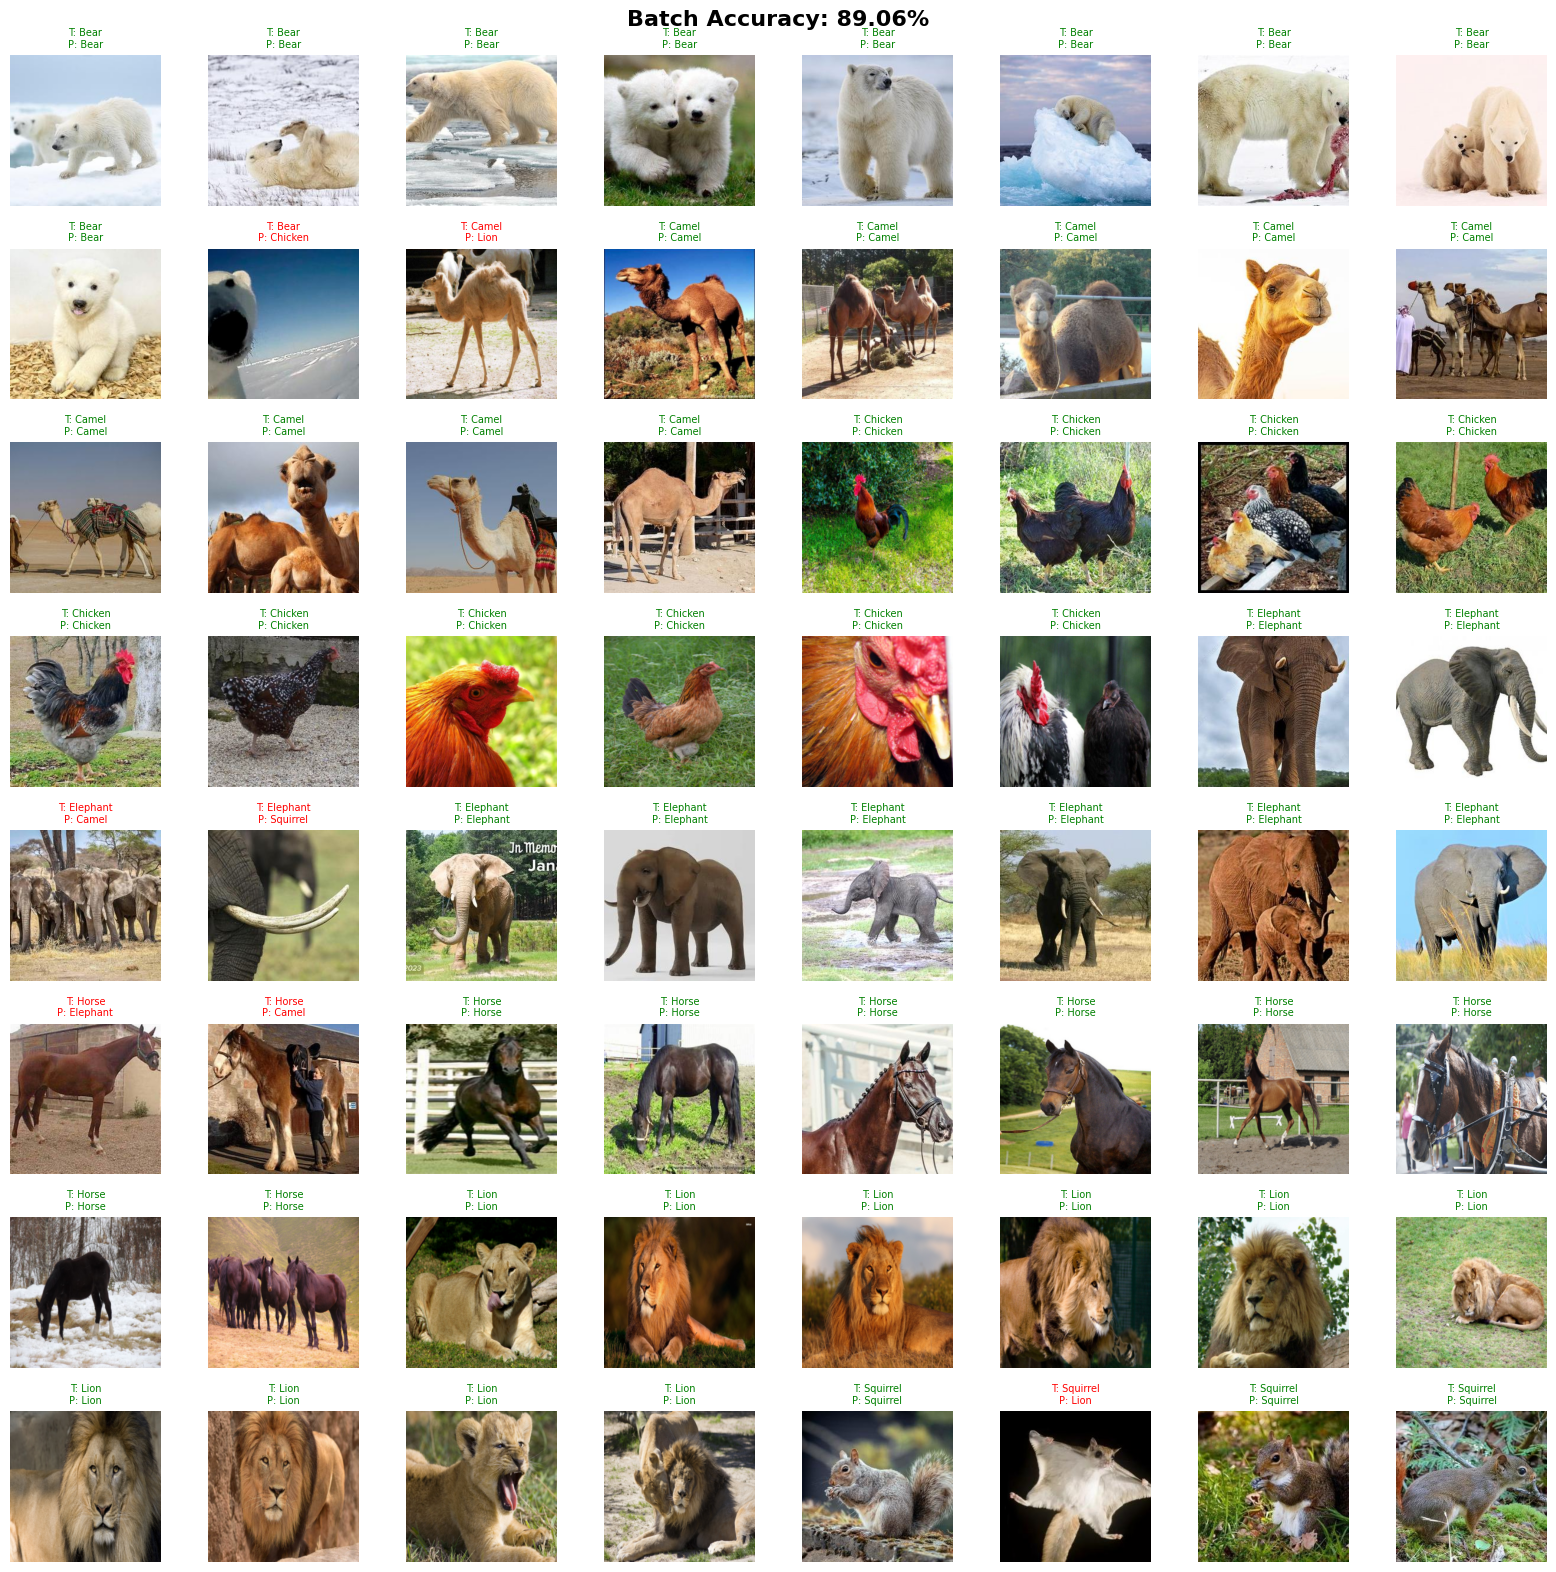

Batch accuracy: 89.06%


In [ ]:
def visualize_predictions(model, test_loader, device, num_images=64, rows=8):
    #Batch of images
    images, labels = next(iter(test_loader))
    images, labels = images.to(device), labels.to(device)

    #calling the model
    model.eval()
    with torch.no_grad():
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)

    #Get the batch accuracy
    correct = (predicted == labels).sum().item()
    accuracy = 100 * correct / len(labels)

    #Create figure
    plt.figure(figsize=(16, 16))
    plt.suptitle(f'Batch Accuracy: {accuracy:.2f}%', fontsize=16, fontweight='bold')

    #show images
    for i in range(min(num_images, len(images))):
        plt.subplot(rows, rows, i+1)

        img_tensor = images[i].cpu().clone()
        img_tensor = img_tensor * 0.5 + 0.5  # Unnormalize
        img = TF.to_pil_image(img_tensor)

        plt.imshow(img)

        true_label = test_loader.dataset.classes[labels[i].item()]
        pred_label = test_loader.dataset.classes[predicted[i].item()]

        #Just setting the color for the labels so they are easy to read
        color = 'green' if predicted[i] == labels[i] else 'red'
        plt.title(f"T: {true_label}\nP: {pred_label}", color=color, fontsize=7)
        plt.axis('off')

    plt.tight_layout()
    plt.savefig('batch_viz.png', dpi=300)
    plt.show()
    print(f'Batch accuracy: {accuracy:.2f}%')


visualize_predictions(model, test_loader, device)